In [1]:
from __future__ import print_function
import torch
import numpy as np
import sinkhorn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import train
import timeit
from linear_run import *
import itertools

one = torch.FloatTensor([1])

In [2]:
def average(v, stepsize=1e-3):
    """
    Average time series on intervals of size stepsize
    """
    v = v[v[:,1].argsort()] 
    h = np.histogram(v[:, 1], bins=np.arange(v[0,1], v[-1, 1], stepsize))
    h_ind = np.where(h[0])
    ind = np.cumsum(h[0][h_ind])
    ind = np.concatenate((np.zeros(1), ind)).astype(int)
    h = h[1][h_ind]
    z = [np.mean(v[ind[i]:ind[i+1], 0]) for i in range(len(h))]
    return h, z

In [3]:
K = 100
dimlambrange = [(20, 0.1), (20, 0.5), (40, 0.1)]
expstart = 1
manual_seed = 137
np.random.seed(seed=manual_seed)
torch.manual_seed(manual_seed)
nexp = 200
cost = sinkhorn._linear_cost
losses = {}

device = torch.device("cpu")
#device = torch.device("cuda:0")

# Sinkhorn

In [4]:
sinkparams = [(5, 1e-2, "adam"), (5, 1e-2, "rms")] # (sinkiter, learningrate, optimizer)

In [5]:
losses['sinkhorn'] = {}
for sinkiter, sinklr, optim in sinkparams:
    for dim,lamb in dimlambrange:
        losses['sinkhorn'][(dim, lamb, sinkiter, sinklr, optim)] = []
        for exp in range(expstart, expstart+nexp):
            l = np.load('experiments/sinkhorn/{0}_lamb{1}_k{2}_dim{3}_sinkiter{4}_lr{5}_sinkhorn_{6}_{7}/losses.npy'.format(exp, lamb, K, dim, sinkiter, sinklr, device, optim))
            t = np.load('experiments/sinkhorn/{0}_lamb{1}_k{2}_dim{3}_sinkiter{4}_lr{5}_sinkhorn_{6}_{7}/time.npy'.format(exp, lamb, K, dim, sinkiter, sinklr, device, optim))
            losses['sinkhorn'][(dim, lamb, sinkiter, sinklr, optim)] += zip(l, t)

# Descent

In [6]:
descentparams = [(0.5, 1e-4, "adam"), (0.1, 1e-2, "adam"), (0.5, 1e-4, "rms"),
                 (0.1, 0.1, "rms")] #(lamb, learningrate, optimizer)

In [7]:
losses['descent'] = {}

for lambd, descentlr, optim in descentparams:
    for dim,lamb in dimlambrange:
        if lamb==lambd:
            losses['descent'][(dim, lamb, descentlr, optim)] = []
            for exp in range(expstart, expstart+nexp):
                l = np.load('experiments/descent/{0}_lamb{1}_k{2}_dim{3}_lr{4}_descent_{5}_{6}/losses.npy'.format(exp, lamb, K, dim, descentlr, device, optim))
                t = np.load('experiments/descent/{0}_lamb{1}_k{2}_dim{3}_lr{4}_descent_{5}_{6}/time.npy'.format(exp, lamb, K, dim, descentlr, device, optim))
                losses['descent'][(dim, lamb, descentlr, optim)] += zip(l,t)

# DC

In [8]:
dcparams = [(5, 1e-5), (5, 1e-4)]

In [9]:
losses['dc'] = {}
for dcdualiter, dclr in dcparams:
    for dim,lamb in dimlambrange:
        losses['dc'][(dim, lamb, dcdualiter, dclr)] = []
        for exp in range(expstart, expstart+nexp):
            l = np.load('experiments/dc/{0}_lamb{1}_k{2}_dim{3}_dualiter{4}_lr{5}_dc_{6}/losses.npy'.format(exp, lamb, K, dim, dcdualiter, dclr, device))
            t = np.load('experiments/dc/{0}_lamb{1}_k{2}_dim{3}_dualiter{4}_lr{5}_dc_{6}/time.npy'.format(exp, lamb, K, dim, dcdualiter, dclr, device))
            losses['dc'][(dim, lamb, dcdualiter, dclr)] += zip(l, t)    

# Plot all

In [11]:
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

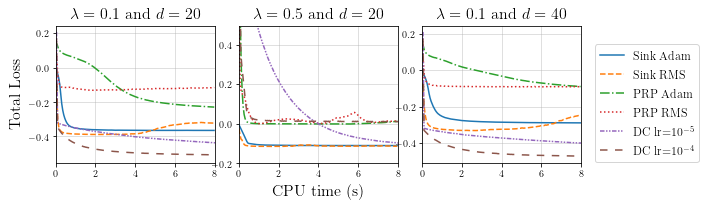

In [12]:
fig = plt.figure()
ls = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1)), (0, (5, 5))]
#ls = ['-', '--', '-.', ':', '-', '--']
##################

for i, z in enumerate(dimlambrange):
    n = 0
    dim, lamb = z
    plt.subplot(131+i)
    if i == 0:
        l = []
    for sinkiter, sinklr, optim in sinkparams:
        h, z = average(np.array(losses['sinkhorn'][(dim, lamb, sinkiter, sinklr, optim)]), stepsize=5e-2)
        lz, = plt.plot(h, z, ls[n])
        n+=1
        if i==0:
            l.append(lz)
        
    for lambd, descentlr, optim in descentparams:
        if lambd==lamb:
            h, z = average(np.array(losses['descent'][(dim, lamb, descentlr, optim)]), stepsize=5e-2)
            lz, = plt.plot(h,z, linestyle=ls[n])
            n+=1
            if i==0:
                l.append(lz)
            
    for dcdualiter, dclr in dcparams:
        h, z = average(np.array(losses['dc'][(dim, lamb, dcdualiter, dclr)]), stepsize=5e-2)
        lz, = plt.plot(h, z, linestyle=ls[n])
        n+=1
        if i==0:
            l.append(lz)

    plt.title('$\lambda={}$ and $d={}$'.format(lamb, dim), fontsize=16)
    if i==0:
        plt.ylabel('Total Loss',fontsize=16)
    if i==1:
        plt.ylim(-0.2, 0.5)
        plt.xlabel('CPU time (s)',fontsize=16)
    #else:
        #plt.tick_params(axis='y', labelleft=False)
    plt.xlim(0, 8)
    plt.grid(alpha=0.5)

labels = ['Sink Adam', 'Sink RMS', 'PRP Adam', 'PRP RMS', 'DC lr=$10^{-5}$', 'DC lr=$10^{-4}$']
fig.set_figheight(2.8)
fig.set_figwidth(10)
plt.subplots_adjust(left=0.1, right=0.83, wspace=0.15, hspace=0, bottom=0.2)
fig.legend(l, labels, 'right', fontsize=12)
plt.savefig('figures/linear-toy.pgf')
plt.show()

Parameters:


First plot:  
- Sink Adam -> learning rate = $1e^{-2}$
- Sink RMS -> learning rate = $1e^{-2}$
- PRP Adam -> $1e^{-2}$
- PRP RMS -> $0.1$
      
      
Second plot:  
- Sink Adam -> $1e^{-2}$
- Sink RMS -> $1e^{-4}$
- PRP Adam -> $1e^{-4}$
- PRP RMS -> $0.1$ 


Third plot: 
- Sink Adam -> learning rate = $1e^{-2}$
- Sink RMS -> learning rate = $1e^{-2}$
- PRP Adam -> $1e^{-2}$
- PRP RMS -> $0.1$

ValueError: setting an array element with a sequence.

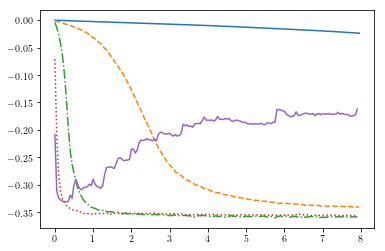

In [29]:
fig = plt.figure()
ls = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1)), (0, (5, 5))]
##################
dimlambrange = [(20, 0.1)]
for i, z in enumerate(dimlambrange):
    n = 0
    dim, lamb = z
    plt.subplot(111+i)
    if i == 0:
        l = []
    for sinkiter, sinklr, optim in sinkparams:  
        h, z = average(np.array(losses['sinkhorn'][(dim, lamb, sinkiter, sinklr, optim)]), stepsize=5e-2)
        lz, = plt.plot(h, z, ls[n])
        n+=1
        if i==0:
            l.append(lz)
        
    for descentlr, optim in descentparams:
        h, z = average(np.array(losses['descent'][(dim, lamb, descentlr, optim)]), stepsize=5e-2)
        lz, = plt.plot(h,z, linestyle=ls[n])
        n+=1
        if i==0:
            l.append(lz)
            
    for dcdualiter, dclr in dcparams:
        h, z = average(np.array(losses['dc'][(dim, lamb, dcdualiter, dclr)]), stepsize=5e-2)
        lz, = plt.plot(h, z, linestyle=ls[n])
        n+=1
        if i==0:
            l.append(lz)

    plt.title('$\lambda={}$, $d={}$, $K={}$'.format(lamb, dim, K), fontsize=16)
    plt.ylabel('Total Loss',fontsize=16)
    plt.xlabel('CPU time (s)',fontsize=16)
    #else:
        #plt.tick_params(axis='y', labelleft=False)
    plt.xlim(0, 8)
    plt.grid(alpha=0.5)

#textstr = '\n'.join((
#    r'$\mu=%.2f$' % (1, ),
#    r'$\mathrm{median}=%.2f$' % (1, ),
#    r'$\sigma=%.2f$' % (1, )))

# place a text box in upper left in axes coords
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plt.text(0.05, -1, textstr, fontsize=14,
#        verticalalignment='bottom', bbox=props)

labels = ['Sink Adam lr=$10^{-2}$', 'Sink RMS lr=$10^{-2}$', 'PRP Adam lr=$10^{-2}$', 'PRP RMS lr=$10^{-1}$', 'DC lr=$10^{-5}$', 'DC lr=$10^{-4}$']
fig.set_figheight(6.2)
fig.set_figwidth(6.8)
plt.subplots_adjust(left=0.1, right=0.95, wspace=0.15, hspace=0, bottom=0.35)
fig.legend(l, labels, 'lower right', fontsize=10)
plt.savefig('figures/linear-toy_single.pgf')
plt.show()